# VAE - gluon (by kk)

In [1]:
import mxnet as mx
from mxnet import nd, autograd, gluon
import numpy as np
from tqdm import tqdm

gpu_ctx = mx.gpu(0)
cpu_ctx = mx.cpu(0)

/home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


# Parameters

In [23]:
FILTERS = 64
LATENT_DIM = 2
BATCH_SIZE = 100
IMG_CHNS = 1

# Define functions

In [3]:
def vae_loss(x, x_gen, z_mean, log_z_var):
    x = nd.flatten(x)
    x_gen = nd.flatten(x_gen)
    #print('x shape = {}'.format(x.shape))
    #print('x_gen sahpe = {}'.format(x_gen.shape))
    # D_KL(q(z|X) || p(z))
    kl_loss = -0.5 * nd.sum(1 + log_z_var - nd.square(z_mean) - nd.exp(log_z_var), axis = 1)
    # E(log p(X|z))
    log_loss = - nd.sum(x* nd.log(x_gen + 1e-6)+ (1-x)*nd.log(1-x_gen + 1e-6), axis=1)
    return nd.sum(kl_loss + log_loss)


    return nd.sum(kl_loss + recon_loss)

def sample_z(args):
    mean, log_var, batch_size, latent_dim = args
    eps = nd.random_normal(shape = (batch_size, latent_dim), loc = 0., scale = 1., ctx = gpu_ctx)
    #print(eps[0:5].asnumpy())
    #print(log_var.shape)
    #print(mean.shape)
    #print(eps.shape)
    return mean + nd.exp(log_var / 2) * eps

class sample_layer(gluon.Block):
    def __init__(self, *args):
        super(sample_layer, self).__init__(*args)
        self.args = args

    def forward(self, x):
        return sample_z(self.args)

# Load Dataset
* transform 함수는 한개의 data에 대해 적용됨
* BATCH SIZE는 무시하고 dimension 변환


In [4]:
mnist = mx.test_utils.get_mnist()

def transform(data, label):
    #print(data.shape)
    res = nd.transpose(data, (2, 0, 1))
    res = res.astype(np.float32) / 255
    return res, label

# lambda data, label: (data.astype(np.float32)/255, label)
train_data = mx.gluon.data.DataLoader( \
                 mx.gluon.data.vision.MNIST( \
                     train = True, \
                     transform = transform), \
                     BATCH_SIZE, shuffle = True)

test_data = mx.gluon.data.DataLoader( \
                 mx.gluon.data.vision.MNIST( \
                     train = False, transform = transform), \
                     BATCH_SIZE, shuffle=False)

# Define Encoder

In [5]:
class Encoder(gluon.Block):
    def __init__(self, filters, latent_dim, **kwarg):
        super(Encoder, self).__init__(**kwarg)
        with self.name_scope():
            # in_channel: 나중에 판단
            # layout: NCHW
            # 1 * 28 * 28
            self.conv2D_1 = gluon.nn.Conv2D(channels = 1, strides = (1, 1), kernel_size = (3, 3), padding = (1, 1), activation = 'relu')
            # 64 * 28 * 28
            self.conv2D_2 = gluon.nn.Conv2D(channels = filters, strides =(1, 1), kernel_size = (3, 3), padding = (1, 1), activation = 'relu')
            # 128 * 14 * 14
            self.conv2D_3 = gluon.nn.Conv2D(channels = 2 * filters, strides = (2, 2), kernel_size = (3, 3), padding= (1, 1), activation = 'relu')
            # 256 * 7 * 7
            self.conv2D_4 = gluon.nn.Conv2D(channels = 4 * filters, strides = (2, 2), kernel_size = (3, 3), padding = (1, 1), activation = 'relu')
            self.flatten = gluon.nn.Flatten()
            self.Dense_1 = gluon.nn.Dense(units = 2 * latent_dim, activation = 'relu')
            
    def forward(self, x):
        #print("input shape : {}".format(x.shape))
        x = self.conv2D_1(x)
        #print("conv2D_1 shape : {}".format(x.shape))
        x = self.conv2D_2(x)
        #print("conv2D_2 shape : {}".format(x.shape))
        x = self.conv2D_3(x)
        #print("conv2D_3 shape : {}".format(x.shape))
        x = self.conv2D_4(x)
        #print("conv2D_4 shape : {}".format(x.shape))
        x = self.flatten(x)
        #print("flatten shape : {}".format(x.shape))
        x = self.Dense_1(x)
        #print("Dense_1 shape : {}".format(x.shape))
        return x

## check encoder dimensions

In [20]:
enc = Encoder(FILTERS, LATENT_DIM)
print(enc)
enc.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx = gpu_ctx)
test_input = nd.random_normal(0,1,(1, 1, 28, 28), ctx = gpu_ctx)
enc(test_input)

Encoder(
  (conv2D_1): Conv2D(None -> 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2D_2): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2D_3): Conv2D(None -> 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2D_4): Conv2D(None -> 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (flatten): Flatten
  (Dense_1): Dense(None -> 4, Activation(relu))
)



[[ 0.01053737  0.00910046  0.          0.0157901 ]]
<NDArray 1x4 @gpu(0)>

# Define Decoder
* in_units는 설정하지 않음
* 여러 block을 사용할 것이므로, name_scope를 꼭 사용

In [13]:
class Decoder(gluon.Block):
    def __init__(self, filters, img_chns, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        with self.name_scope():
            self.dense_1 = gluon.nn.Dense(units = 7 * 7 * filters * 4, activation = 'relu')
            # 256 * 7 * 7
            self.conv_trans_1 = gluon.nn.Conv2DTranspose(channels = filters * 4, kernel_size = (3, 3)\
                                                         , strides = (1, 1), padding = (1, 1), output_padding = (0, 0)\
                                                         , activation = 'relu')
            # 128 * 14 * 14 
            self.conv_trans_2 = gluon.nn.Conv2DTranspose(channels = filters * 2, kernel_size = (3, 3)\
                                                         , strides = (2, 2), padding = (1, 1), output_padding = (1, 1)\
                                                         , activation = 'relu')
            # 64 * 28 * 28
            self.conv_trans_3 = gluon.nn.Conv2DTranspose(channels = filters, kernel_size = (3, 3)\
                                                         , strides = (2, 2), padding = (1, 1), output_padding = (1, 1)\
                                                         , activation = 'relu')
            # 1 * 28 * 28
            self.conv_trans_4 = gluon.nn.Conv2DTranspose(channels = img_chns, kernel_size = (3, 3)\
                                                         , strides = (1, 1), padding = (1, 1), output_padding = (0, 0)\
                                                         , activation = 'sigmoid')
    
    def forward(self, x):
        x = self.dense_1(x)
        #print('after dense....%s'%str(x.shape))
        x = x.reshape((-1, FILTERS * 4, 7, 7))
        #print('after reshape....%s'%str(x.shape))
        x = self.conv_trans_1(x)
        #print('after conv_trans_1.... %s'%str(x.shape))
        x = self.conv_trans_2(x)
        #print('after conv_trans_2.... %s'%str(x.shape))
        x = self.conv_trans_3(x)
        #print('after conv_trans_3.... %s'%str(x.shape))
        x = self.conv_trans_4(x)
        #print('after conv_trans_4.... %s'%str(x.shape))
        return x

## Check decoder dimensions
* 4-dim으로 reshape NCHW
* decoder의 input으로 (-1, HIDDEN_DIM)으로 변환해서 넣어주어야 함 (data.reshape(-1, HIDDEN_DIM) 이용)

In [14]:
dec = Decoder(FILTERS, IMG_CHNS)
print(dec)
dec.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx = gpu_ctx)
# Simulate dimension
test_input = nd.random_normal(0,1,shape= LATENT_DIM, ctx = gpu_ctx)
test_input = test_input.reshape((-1, LATENT_DIM))
dec(test_input).shape

Decoder(
  (dense_1): Dense(None -> 12544, Activation(relu))
  (conv_trans_1): Conv2DTranspose(256 -> 0, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_trans_2): Conv2DTranspose(128 -> 0, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_trans_3): Conv2DTranspose(64 -> 0, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_trans_4): Conv2DTranspose(1 -> 0, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


(1, 1, 28, 28)

In [15]:
# Batch size가 필요함
# name_scope를 사용해야 함
class VAE(gluon.Block):
    def __init__(self, batch_size, filters, latent_dim, img_chns, **kwargs):
        super(VAE, self).__init__(**kwargs)
        with self.name_scope():
            self.enc = Encoder(filters, latent_dim)
            self.dec = Decoder(filters, img_chns)
            self.latent_dim = latent_dim
            self.batch_size = batch_size
            # 어떤 모양으로 들어올지 모르기 때문
            self.z_mean = nd.zeros((batch_size, latent_dim), ctx = gpu_ctx)
            self.log_z_var = nd.zeros((batch_size, latent_dim), ctx = gpu_ctx)
        
    def forward(self, x):
        x = self.enc(x)
        #print('x\'s shape after enc = {}'.format(x.shape))
        self.z_mean = x.slice(begin = (None, 0), end = (None, self.latent_dim))
        self.log_z_var = x.slice(begin = (None, self.latent_dim), end = (None, 2 * self.latent_dim))
        z = sample_z([self.z_mean, self.log_z_var, self.batch_size, self.latent_dim])
        #print('z\'s shape = {}'.format(z.shape))
        #print('z_mean\'s shape = {}'.format(self.log_z_var.shape))
        #print('log_z_var\'s shape = {}'.format(self.log_z_var.shape))
        x_gen = self.dec(z)
        return x_gen, self.z_mean, self.log_z_var

In [16]:
vae = VAE(BATCH_SIZE, FILTERS, LATENT_DIM, IMG_CHNS)
print(vae)

VAE(
  (enc): Encoder(
    (conv2D_1): Conv2D(None -> 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2D_2): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2D_3): Conv2D(None -> 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2D_4): Conv2D(None -> 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (flatten): Flatten
    (Dense_1): Dense(None -> 4, Activation(relu))
  )
  (dec): Decoder(
    (dense_1): Dense(None -> 12544, Activation(relu))
    (conv_trans_1): Conv2DTranspose(256 -> 0, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_trans_2): Conv2DTranspose(128 -> 0, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_trans_3): Conv2DTranspose(64 -> 0, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv_trans_4): Conv2DTranspose(1 -> 0, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


## Check VAE dimensions

In [17]:
# Simulate dimension
test_input = nd.random_normal(0,1,shape= (1, 1, 28, 28), ctx = gpu_ctx)
vae.collect_params().initialize(mx.init.Xavier(magnitude= 2.24), ctx = gpu_ctx)
vae(test_input)[0].shape

(128, 1, 28, 28)

# Define Trainer

In [18]:
trainer = gluon.Trainer(vae.collect_params(), 'adam', {'learning_rate': .001})

# Training

In [24]:
EPOCHS = 100

los = []
for e in range(EPOCHS):
    for i, (data, label) in enumerate(train_data):
        x = data.as_in_context(gpu_ctx)
        
    with autograd.record():
        if i == 0:
            print('...start algorithm')
        x_gen, z_mean, log_z_var = vae(x)
        loss = vae_loss(x, x_gen, z_mean, log_z_var)
    loss.backward()
    trainer.step(data.shape[0])
    print('epoch: {}, cur_loss = {}'.format(e, loss))
    los.append(loss.asnumpy())
        

MXNetError: [09:33:39] src/operator/tensor/./elemwise_binary_broadcast_op.h:67: Check failed: l == 1 || r == 1 operands could not be broadcast together with shapes [96,2] [128,2]

Stack trace returned 10 entries:
[bt] (0) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x28965c) [0x7fa9e5daa65c]
[bt] (1) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x90a7ff) [0x7fa9e642b7ff]
[bt] (2) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x24d573f) [0x7fa9e7ff673f]
[bt] (3) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x24c1be9) [0x7fa9e7fe2be9]
[bt] (4) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x24026bb) [0x7fa9e7f236bb]
[bt] (5) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/site-packages/mxnet/libmxnet.so(MXImperativeInvokeEx+0x63) [0x7fa9e7f23bf3]
[bt] (6) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x7faa20352ec0]
[bt] (7) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call+0x22d) [0x7faa2035287d]
[bt] (8) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(_ctypes_callproc+0x2ce) [0x7faa2056782e]
[bt] (9) /home/kionkim/anaconda3/envs/kion_venv_mxnet/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(+0x12265) [0x7faa20568265]


## Save model

In [1]:
# Path to save parameters
model_prefix = 'vae_gluon_MLP.params'
vae.save_params(model_prefix)

NameError: name 'vae' is not defined

# Predict

## Load model

In [22]:
NUM_TEST = 10

In [23]:
vae2 = VAE(NUM_TEST, FILTERS, LATENT_DIM, IMG_CHNS)
vae2.load_params(model_prefix, ctx=gpu_ctx)

## Get original image

In [24]:
for i, (data) in enumerate(test_data):
    original_image = data[0][0:NUM_TEST, :, :, :]
    if i == 1:
        break

## Reconstruct image
  * vae2의 결과물은 [x_gen, z_mean, z_log_var]의 list형태

In [25]:
result = vae2(original_image.as_in_context(gpu_ctx))
result = result[0].asnumpy()
original = original_image.asnumpy()

(10, 2)
(10, 2)
(10, 2)


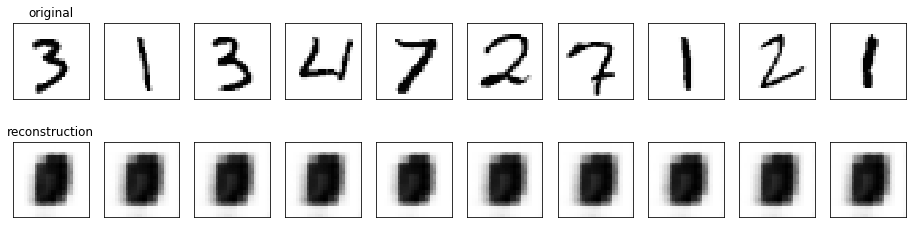

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

n_samples = original_image.shape[0]

_, axarr = plt.subplots(2, n_samples, figsize=(16,4))

for i, x in enumerate(original):
    axarr[0,i].imshow(x.reshape((28,28)), cmap='Greys')
    if i==0:
        axarr[0,i].set_title('original')
    #axarr[0,i].axis('off')
    axarr[0,i].get_xaxis().set_ticks([])
    axarr[0,i].get_yaxis().set_ticks([])

    axarr[1,i].imshow(result[i].reshape((28,28)), cmap='Greys')
    if i==0:
        axarr[1,i].set_title('reconstruction')
    #axarr[1,i].axis('off')
    axarr[1,i].get_xaxis().set_ticks([])
    axarr[1,i].get_yaxis().set_ticks([])
plt.show()

after dense....(1, 12544)
after reshape....(1, 256, 7, 7)
after conv_trans_1.... (1, 256, 7, 7)
after conv_trans_2.... (1, 128, 14, 14)
after conv_trans_3.... (1, 64, 28, 28)
after conv_trans_4.... (1, 1, 28, 28)


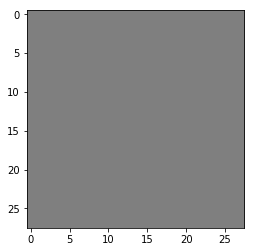

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

test_input = nd.random_normal(loc = 0,scale = 2,shape= LATENT_DIM, ctx = gpu_ctx)
t_i = test_input.reshape((-1, LATENT_DIM))
test_gen = dec(t_i)
t_g = nd.transpose(test_gen, (0, 2, 3, 1))
im = nd.transpose(t_g,(1,0,2,3))
im = nd.reshape(im,(28, 28,1))
imtiles = nd.tile(im, (1,1,3))
plt.imshow(imtiles.asnumpy())
plt.show()

In [28]:
test_gen


[[[[ 0.50028056  0.50006336  0.50001007  0.50009346  0.49996209  0.50000113
     0.49992168  0.49999869  0.50012594  0.50015461  0.49982446  0.49991751
     0.50012875  0.49998283  0.500054    0.50003207  0.49995345  0.50020087
     0.50006247  0.50009751  0.50001132  0.50002122  0.50020128  0.50011408
     0.50015682  0.50007886  0.50016648  0.49989346]
   [ 0.50011837  0.50011653  0.50027168  0.50032485  0.50028926  0.50001252
     0.50006485  0.49996322  0.50024915  0.50002694  0.50019926  0.50000727
     0.50022888  0.50010306  0.50001353  0.50021893  0.5002014   0.4999401
     0.50021875  0.49995762  0.50036168  0.50027966  0.49988237  0.50007564
     0.50023842  0.50001597  0.50022185  0.50012606]
   [ 0.50005227  0.49979421  0.50009608  0.49971488  0.50017655  0.50009847
     0.5001843   0.49974751  0.50009674  0.49989203  0.50011927  0.49963233
     0.50005466  0.50025785  0.49996638  0.49961466  0.49995768  0.49970406
     0.50039279  0.49965215  0.50003338  0.50002873  0.500

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def model_predict(net,data):
    output = dec(data.as_in_context(model_ctx))
    return nd.argmax(output, axis=1)

NUM_EXAMPLES = 10
# let's sample 10 random data points from the test set
sample_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=transform),
                              NUM_EXAMPLES, shuffle=True)

for i, (data, label) in enumerate(sample_data):
    data = data.as_in_context(gpu_ctx)
    data_t = nd.transpose(data, (0, 2, 3, 1))
    im1 = nd.transpose(data,(1, 0, 2, 3))
    im1 = nd.reshape(im1,(28, NUM_EXAMPLES * 28,1))
    imtiles1 = nd.tile(im1, (1,1,3))
    
    gen, _, _ = vae(data)
    gen_t = nd.transpose(gen, (0, 2, 3, 1))
    im2 = nd.transpose(gen_t,(1, 0, 2, 3))
    im2 = nd.reshape(im2,(28, NUM_EXAMPLES * 28, 1))
    imtiles2 = nd.tile(im2, (1,1,3))
    
    f, (plt1, plt2) = plt.subplots(2, 1)
    plt1.imshow(imtiles1.asnumpy())
    plt2.imshow(imtiles2.asnumpy())
    f.show()
    #pred=model_predict(net,data.reshape((-1,784)))
    #print('model predictions are:', pred)
    break